# *Import Libraries*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# *Define functions*

In [2]:
def load_pickle(file_name):
    infile = open(file_name, 'rb')
    df = pickle.load(infile)
    infile.close()
    return df

# *Load data*
## Dictionary
- CFR = Case Fatality Ratio -> Death / Total Case
- RI = Recovery Index -> Recovered / Total Case
- RLI = Rasio Lacak Isolasi -> (OTG + ODP + Suspect + Probable)/Total Case

In [3]:
df_province_summary = load_pickle('files/df_province_summary')
df_pcr = load_pickle('files/df_pcr')
df_active_case = load_pickle('files/df_active_case')
df_mobility = pd.read_csv('files/Mobility.csv', sep=';')

df_daily_case = load_pickle('files/df_daily_case')
df_daily_death = load_pickle('files/df_daily_death')
df_daily_recovered = load_pickle('files/df_daily_recovered')

df_total_case = load_pickle('files/df_total_case')
df_total_death = load_pickle('files/df_total_death')
df_total_recovered = load_pickle('files/df_total_recovered')

# *General Statistics*
## Metrics
- p0 (Progress to Zero): https://www.medrxiv.org/content/10.1101/2020.05.21.20109298v1.full.pdf+html
- R0 (R-naught): https://www.nytimes.com/2020/04/23/world/europe/coronavirus-R0-explainer.html
- RLI (Rasio Lacak Isolasi): https://kawalcovid19.id/content/1294/serial-data-virus-korona-2-rasio-lacak-isolasi-rli-dan-korelasinya-dengan-kematian-kumulatif

Let's start by seing the proportion of total_case, total_death and total_recovered for provinces in Indonesia. For the sake of better visualization, let's start by seeing 5 provinces with top total case.

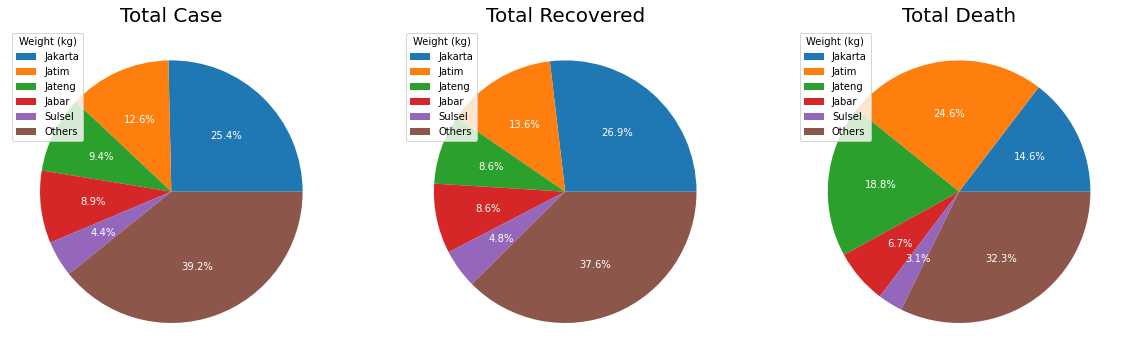

In [4]:
df_province_summary.sort_values(by='Covid19+ Total', ascending=False, inplace=True)

total_case = df_province_summary.iloc[:5,12]
total_case.loc['Others'] = df_province_summary.iloc[5:,12].sum()

total_recovered = df_province_summary.iloc[:5,14]
total_recovered.loc['Others'] = df_province_summary.iloc[5:,14].sum()

total_death = df_province_summary.iloc[:5,15]
total_death.loc['Others'] = df_province_summary.iloc[5:,15].sum()

# --------------------------- PLOT ---------------------------
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20,10))
wedges, text, autotexts = ax1.pie(total_case, autopct='%1.1f%%', textprops={'color':"w"})
ax1.set_title('Total Case', fontsize = 20)
ax1.legend(wedges, total_case.index, title="Weight (kg)", loc="upper left", fontsize=10)

wedges, text, autotexts = ax2.pie(total_recovered, autopct='%1.1f%%', textprops={'color':"w"})
ax2.set_title('Total Recovered', fontsize = 20)
ax2.legend(wedges, total_recovered.index, title="Weight (kg)", loc="upper left", fontsize=10)

wedges, text, autotexts = ax3.pie(total_death, autopct='%1.1f%%', textprops={'color':"w"})
ax3.set_title('Total Death', fontsize = 20)
ax3.legend(wedges, total_death.index, title="Weight (kg)", loc="upper left", fontsize=10)

Next, let's see the distribution each category more spesifically.

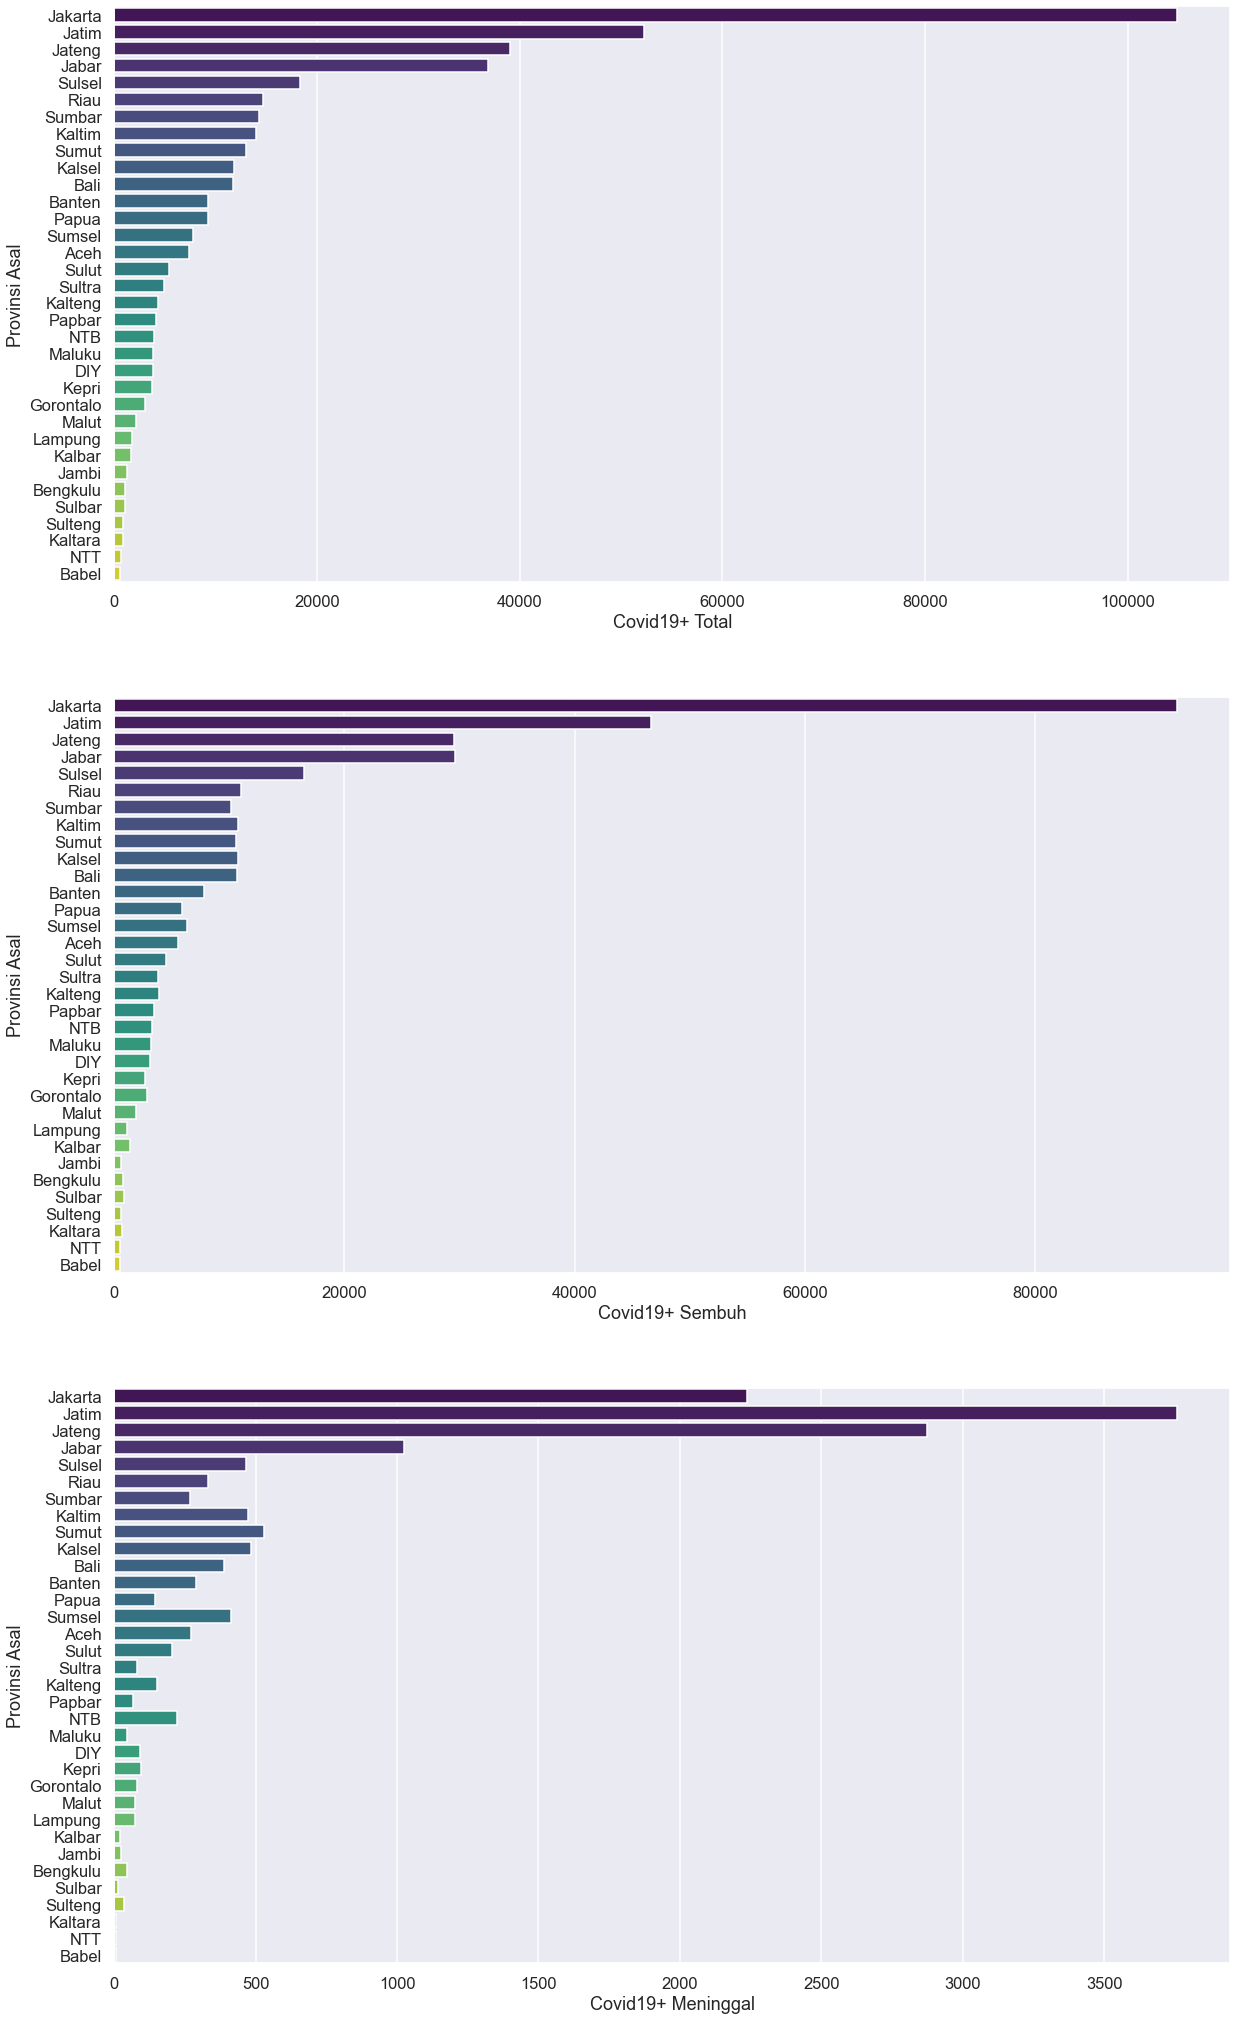

In [5]:
sns.set_context('talk')
sns.set_style('darkgrid')
fig, (ax1,ax2,ax3) = plt.subplots(ncols=1, nrows=3, figsize=(20,36))

sns.barplot(x='Covid19+ Total', y='Provinsi Asal', data=df_province_summary.reset_index(), palette='viridis', ax=ax1)
ax1.grid(b=True, which='minor', linestyle='--')

sns.barplot(x='Covid19+ Sembuh', y='Provinsi Asal', data=df_province_summary.reset_index(), palette='viridis', ax=ax2)
ax2.grid(b=True, which='minor', linestyle='--')

sns.barplot(x='Covid19+ Meninggal', y='Provinsi Asal', data=df_province_summary.reset_index(), palette='viridis', ax=ax3)
ax3.grid(b=True, which='minor', linestyle='--')

Now let's see the recovered and death ratio for each city. 
- Red vertical line is national recovered ratio and national death ratio

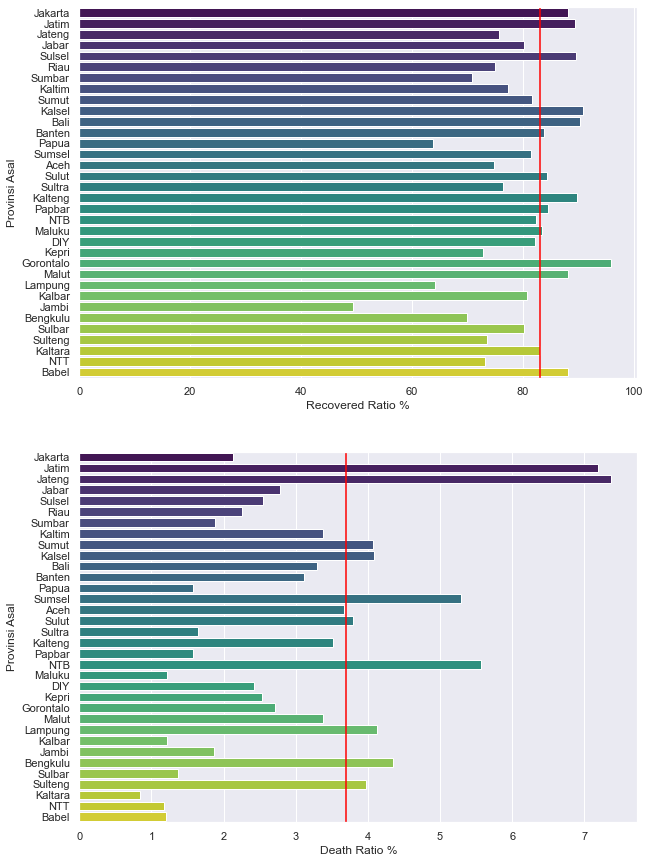

In [6]:
sns.set_context('notebook')
sns.set_style('darkgrid')

national_recovered_ratio = df_province_summary['Covid19+ Sembuh'].sum()*100/df_province_summary['Covid19+ Total'].sum()
national_death_ratio = df_province_summary['Covid19+ Meninggal'].sum()*100/df_province_summary['Covid19+ Total'].sum()

df_province_summary['Death Ratio %'] = df_province_summary['Covid19+ Meninggal']*100/df_province_summary['Covid19+ Total']
df_province_summary['Recovered Ratio %'] = df_province_summary['Covid19+ Sembuh']*100/df_province_summary['Covid19+ Total']

fig, (ax1,ax2) = plt.subplots(ncols = 1, nrows=2, figsize=(10, 15))
sns.barplot(x='Recovered Ratio %', y='Provinsi Asal', data=df_province_summary.reset_index(), palette='viridis', ax=ax1)
ax1.axvline(national_recovered_ratio, color='r', label='Nationa Average')

sns.barplot(x='Death Ratio %', y='Provinsi Asal', data=df_province_summary.reset_index(), palette='viridis', ax=ax2)
ax2.axvline(national_death_ratio, color='r', label='Nationa Average')

- It appears that java island is still the dominant area of virus spreadness. It is shown by 4 province with most cases are in java.
- Spesifically, one fourth of total case came from Jakarta. However, Jakarta seemed better in reducing death cases than East Java and West Java.

# *Timeline each province*

In [7]:
df_total_case.columns
# df_total_case['date'] = pd.date_range(start='03/18/2020', end='31/10/2020', freq='D')
# df_total_case

Index(['Total Kasus', 'Aceh', 'Bali', 'Banten', 'Babel', 'Bengkulu', 'DIY',
       'Jakarta', 'Jambi', 'Jabar', 'Jateng', 'Jatim', 'Kalbar', 'Kaltim',
       'Kalteng', 'Kalsel', 'Kaltara', 'Kepri', 'NTB', 'Sumsel', 'Sumbar',
       'Sulut', 'Sumut', 'Sultra', 'Sulsel', 'Sulteng', 'Lampung', 'Riau',
       'Malut', 'Maluku', 'Papbar', 'Papua', 'Sulbar', 'NTT', 'Gorontalo'],
      dtype='object')